In [2]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm

from dateutil.parser import parse as DateParser
import os

def _dict_lower_keys(d):
    return {k.lower():v for k,v in d.items()}


condir = '/home/lordluen/Code/InsightDS/Legis_data/contributions/'

In [3]:
FIELD_SPECS={
    'year': int,
    'amount': float,
    'registrantid': int,
    'received': DateParser,
    'contributiondate': DateParser,
    'contributiontype': str,
    'honoree': str,
}

In [8]:
path_to_file = condir+"2016_2_6_1_LD203.xml"
print(path_to_file)

/home/lordluen/Code/InsightDS/Legis_data/contributions/2016_2_6_1_LD203.xml


In [77]:
bar = {key for key in FIELD_SPECS.items()}
print(bar)
for key,cast in FIELD_SPECS.items():
    bar[key].append(cast(data[key])) 

{('honoree', <class 'str'>), ('amount', <class 'float'>), ('received', <function parse at 0x7f56b415c7b8>), ('contributiondate', <function parse at 0x7f56b415c7b8>), ('registrantid', <class 'int'>), ('year', <class 'int'>), ('contributiontype', <class 'str'>)}


TypeError: 'set' object is not subscriptable

In [9]:
fd = open(path_to_file)
dom = ET.fromstring(fd.read())

In [10]:
counter = 0
data = {}
data_topush = {}
foo = True
alldat = pd.DataFrame()
for filing in tqdm(dom.findall('.//Filing')):
    for reg in filing.findall('.//Registrant'):
        for child in filing.findall('.//Contribution'):
            data.clear()
            data_topush.clear()
            data.update(_dict_lower_keys(filing.attrib))
            data.update(_dict_lower_keys(child.attrib))
            data.update(_dict_lower_keys(reg.attrib))
            data_topush = {key:cast(data[key]) for key,cast in FIELD_SPECS.items()}

            for key,cast in FIELD_SPECS.items():
                alldat.loc[counter,key] = cast(data[key])
            counter = counter + 1
            
alldat['year'] = alldat['year'].astype(int)
#alldat['registrantid'] = alldat['registrantid'].astype(int)


100%|██████████| 10/10 [00:00<00:00, 39162.50it/s]


In [11]:
alldat.head(20)

""


In [84]:
print(type(alldat['year'].iloc[0]))

<class 'numpy.float64'>


In [87]:
alldat['year'] = alldat['year'].astype(int)

In [12]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder

from operator import attrgetter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [14]:
raw_bills = bills.read_bills( start_year = 2015 )

In [15]:
type(raw_bills)

generator

In [16]:
data = pd.DataFrame.from_dict( raw_bills )

100%|██████████| 119/119 [00:01<00:00, 88.91it/s]


In [17]:
data.head(2)

,category,chamber,congress,date,number,result,subjects,top_subject,type
0,amendment,s,114,2015-03-26 23:23:00-04:00,11,Amendment Agreed to,"[Accounting and auditing, Administrative law a...",Economics and public finance,sconres
1,amendment,s,114,2015-12-03 19:06:00-05:00,3762,Amendment Rejected,"[Abortion, Appropriations, Drug trafficking an...",Health,hr


In [18]:
foo = list()
for i in data['subjects']:
    foo = foo+i

In [19]:
print(foo[0])

Accounting and auditing


In [20]:
nfoo = np.asarray(foo)

In [21]:
bar = np.unique(nfoo)

In [22]:
print(bar)

['ASEAN countries' 'Abortion' 'Academic performance and assessments'
 'Access Board' 'Accidents' 'Accounting and auditing'
 'Administrative Conference of the U.S.'
 'Administrative law and regulatory procedures' 'Administrative remedies'
 'Adoption and foster care' 'Adult education and literacy'
 'Advanced technology and technological innovations' 'Advisory bodies'
 'Afghanistan' 'Africa' 'African Development Foundation'
 'Age discrimination' 'Aging' 'Agricultural conservation and pollution'
 'Agricultural education' 'Agricultural insurance'
 'Agricultural marketing and promotion'
 'Agricultural practices and innovations'
 'Agricultural prices, subsidies, credit' 'Agricultural research'
 'Agricultural trade' 'Agriculture and food' 'Air quality' 'Alabama'
 'Alaska' 'Alaska Natives and Hawaiians' 'Alcoholic beverages' 'Alliances'
 'Allied health services' 'Alternative and renewable resources'
 'Alternative dispute resolution, mediation, arbitration'
 'Alternative treatments' 'American Ba

In [23]:
print(bar[0])

ASEAN countries


In [25]:
print(bar[-7])

Women's rights


In [29]:
subs = pd.DataFrame()

In [35]:
subs['subjects'] = bar
subs.head(-1)

,subjects
0,ASEAN countries
1,Abortion
2,Academic performance and assessments
3,Access Board
4,Accidents
5,Accounting and auditing
6,Administrative Conference of the U.S.
7,Administrative law and regulatory procedures
8,Administrative remedies
9,Adoption and foster care


In [36]:
#set up engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)



In [38]:
sqlCommands.append_to_database(dbname,'topics',subs,engine)

In [ ]:
query = "SELECT * FROM topics;"

bills_df = pd.read_sql_query(query,engine)

In [1]:
import os
import numpy as np
import pandas as pd
import ujson as json
from tqdm import tqdm
from sqlCommands import append_to_database

from dateutil.parser import parse as DateParser

CURR_CONGRESS = 114
RESULTMAP = {
    "INTRODUCED":2,
    "REFERRED":2,
    "REPORTED":2,
    "PROV_KILL:SUSPENSIONFAILED":0,
    "PROV_KILL:CLOTUREFAILED":0,
    "FAIL:ORIGINATING:HOUSE":0,
    "FAIL:ORIGINATING:SENATE":0,
    "PASSED:SIMPLERES":1,
    "PASSED:CONSTAMEND":1,
    "PASS_OVER:HOUSE":2,
    "PASS_OVER:SENATE":2,
    "PASSED:CONCURRENTRES":1,
    "FAIL:SECOND:HOUSE":0,
    "FAIL:SECOND:SENATE":0,
    "PASS_BACK:HOUSE":2,
    "PASS_BACK:SENATE":2,
    "PROV_KILL:PINGPONGFAIL":0,
    "PASSED:BILL":1,
    "CONFERENCE:PASSED:HOUSE":2,
    "CONFERENCE:PASSED:SENATE":2,
    "ENACTED:SIGNED":1,
    "PROV_KILL:VETO":1,
    "VETOED:POCKET":1,
    "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE":1,
    "VETOED:OVERRIDE_FAIL_ORIGINATING:SENATE":1,
    "VETOED:OVERRIDE_PASS_OVER:HOUSE":1,
    "VETOED:OVERRIDE_PASS_OVER:SENATE":1,
    "VETOED:OVERRIDE_FAIL_SECOND:HOUSE":1,
    "VETOED:OVERRIDE_FAIL_SECOND:SENATE":1,
    "ENACTED:VETO_OVERRIDE":1,
    "ENACTED:TENDAYRULE":1
}


In [2]:
bill_file = '/home/lordluen/Code/InsightDS/Legis_data/votes/113/bills/hr/hr1960/data.json'
data = json.load(open(bill_file))

In [3]:
allcoms = data['committees']
print(type(allcoms))

<class 'list'>


In [5]:
coms = list()
for c in allcoms:
    coms.append(c['committee_id'])

In [7]:
print(np.unique(coms))

['HSAS' 'HSHM' 'HSPW']


In [89]:
active = data['history']['active']
print(type(active))
print(active)
if active == True:
    print('yay')

<class 'bool'>
True
yay


In [96]:
    #data = json.load(bill_file)
    subjects=list(data['subjects'])
    top_subject=data['subjects_top_term']
    bill_type = data['bill_type']
    bill_number = data['number']
    title = data['short_title']
    ltitle = data['official_title']
    amends = data['amendments']
    congress = int(data['congress'])
    num_amends = len(amends)
    status = data['status']
    intro_date = DateParser(data['introduced_at'])
    active = data['history']['active']
    try:
        final_date = DateParser((data['summary'])['date'])
    except:
        final_date = None
    tsponsor = data['sponsor']
    if tsponsor['type'] == 'person': #lets only use bills from people, not committees. Since funding would be hard to trace otherwise.
        sponsor = [tsponsor['title'],tsponsor['name'],tsponsor['state']]
        tcosponsors = data['cosponsors']
        cosponsors = list()
        if len(tcosponsors) > 0:
            for co in tcosponsors:
                cosponsors.append([co['title'],co['name'],co['state']])
    foo = pd.DataFrame()
    foo['subjects'] = [subjects]
    foo['top_subject'] = top_subject
    foo['bill_type'] = bill_type
    foo['bill_number'] = bill_number
    foo['status'] = status
    foo['result'] = foo['status'].map(RESULTMAP) #0 = failed, 1 = passed, 2 = pending
    foo['sponsor'] = [sponsor]
    foo['cosponsors'] = [cosponsors]
    foo['intro_date'] = intro_date
    foo['final_date'] = final_date
    foo['title'] = title
    foo['num_amends'] = num_amends
    foo['otitle'] = ltitle
    foo['congress'] = int(congress)
    #foo['active'] = active.map({'True':1,'False':0})
    if active == True:
        foo['active'] = [1]
    if active == False:
        foo['active'] = [0]
    #if result = 2 and active = 0 then bill died on table.
    #if (foo['result'].iloc[0] == 2) and (active == False):
    #    foo['final_result'] = foo['active']
    #else:
    #    foo['final_result'] = foo['result']
    foo['final_result'] = foo['result']
    if (foo['result'].iloc[0] == 2) and (congress < CURR_CONGRESS):
        foo['final_result'] = [0]


In [97]:
print(type(foo['result'].iloc[0]))
print(type(congress))

<class 'numpy.int64'>
<class 'int'>


In [102]:
foo[['congress','result','final_result']]

,congress,result,final_result
0,113,2,0


In [78]:
foo = pd.DataFrame()
foo['active'] = [1]

In [81]:
print(foo['active'].iloc[0])

1


In [85]:
congress = int(data['congress'])
print(congress)
print(type(congress))

113
<class 'int'>


In [86]:
if congress < 114:
    print('yay')

yay


In [9]:
amends = data['amendments']
a = amends[0]

In [10]:
print(type(amends))
print(len(amends))
print(type(a))
print(a)

<class 'list'>
35
<class 'dict'>
{'amendment_type': 'hamdt', 'amendment_id': 'hamdt141-113', 'chamber': 'h', 'number': '141'}


In [12]:
foo = len([])
print(foo)

0


In [13]:
subjects=list(data['subjects'])
top_subject=data['subjects_top_term']
bill_type = data['bill_type']
status = data['status']
tsponsor = data['sponsor']
intro_date = DateParser(data['introduced_at'])
try:
    final_date = DateParser((data['summary'])['date'])
except:
    final_date = DateParser('9999-09-09')
if tsponsor['type'] == 'person': #lets only use bills from people, not committees. Since funding would be hard to trace otherwise.
    sponsor = [tsponsor['title'],tsponsor['name'],tsponsor['state']]
tcosponsors = data['cosponsors']
cosponsors = list()
if len(tcosponsors) > 0:
    for co in tcosponsors:
        cosponsors.append([co['title'],co['name'],co['state']])
foo = pd.DataFrame()
foo['subjects'] = [subjects]
foo['top_subject'] = top_subject
foo['bill_type'] = bill_type
foo['status'] = status
foo['sponsor'] = [sponsor]
foo['cosponsors'] = [cosponsors]
foo['intro_date'] = intro_date
foo['final_date'] = final_date

In [14]:
foo

,subjects,top_subject,bill_type,status,sponsor,cosponsors,intro_date,final_date
0,"[Administrative remedies, Advanced technology ...",Armed forces and national security,hr,PASS_OVER:HOUSE,"[Rep, McKeon, Howard P. ""Buck"", CA]","[[Rep, Smith, Adam, WA]]",2013-05-14,2013-06-14


In [34]:
sponsors = list(foo['sponsor'])
cosponsors = list(foo['cosponsors'])

In [36]:
#print(np.unique(sponsors))
#print(sponsors)
#print(type(cosponsors[0]))
bleh = cosponsors[0]
print(type(bleh))
print(bleh)
print(type(sponsors))
allspons = sponsors+cosponsors[0]
print(allspons)

<class 'list'>
[['Rep', 'Smith, Adam', 'WA']]
<class 'list'>
[['Rep', 'McKeon, Howard P. "Buck"', 'CA'], ['Rep', 'Smith, Adam', 'WA']]


In [25]:
print(allspons)

[['Rep', 'McKeon, Howard P. "Buck"', 'CA', ['Rep', 'Smith, Adam', 'WA']]]


In [95]:
sponsor = info['sponsor']
subjects = info['subjects']
cosponsors = info['cosponsors']

In [96]:
print(type(sponsor))
print(type(subjects))
print(type(cosponsors))

<class 'list'>
<class 'list'>
<class 'list'>


In [98]:
print(sponsor)
print(subjects)
print(cosponsors)

['Rep', 'Weygand, Robert A.', 'RI']
['Chemicals', 'Commerce', 'Dyes and dyeing', 'Environmental protection', 'Foreign trade and international finance', 'Tariff']
[]


In [104]:
bar = pd.DataFrame()
bar['sponsor'] = [sponsor]
bar['subjects'] = [subjects]
bar['cosponsors'] = [cosponsors]
bar

,sponsor,subjects,cosponsors
0,"[Rep, Weygand, Robert A., RI]","[Chemicals, Commerce, Dyes and dyeing, Environ...",[]


In [94]:
foo = pd.DataFrame.from_dict(info)
foo

ValueError: arrays must all be same length

In [89]:
print(info['sponsor'])

['Rep', 'Weygand, Robert A.', 'RI']


In [82]:
foo = cosponsors[0]

IndexError: list index out of range

In [73]:
print(foo)

{'district': None, 'withdrawn_at': None, 'state': 'OR', 'sponsored_at': '2003-11-17', 'title': 'Sen', 'thomas_id': '01247', 'name': 'Wyden, Ron'}


In [74]:
print(type(foo))

<class 'dict'>


In [75]:
print(info['cosponsors'])

[[['Sen', 'Wyden, Ron', 'OR']]]


In [83]:
print(info)

{'sponsor': ['Rep', 'Weygand, Robert A.', 'RI'], 'cosponsors': [], 'status': 'REFERRED', 'top_subject': 'Foreign trade and international finance', 'type': 'hr', 'subjects': ['Chemicals', 'Commerce', 'Dyes and dyeing', 'Environmental protection', 'Foreign trade and international finance', 'Tariff']}


In [84]:
#bleh = ['a','b','c']
bleh = info['sponsor']
print(bleh)
print(type(bleh))
print(bleh[0])
print(bleh[1])
print(bleh[2])
bar = pd.DataFrame(columns=['sponsor'])
bar['sponsor'] = [bleh]
#bar['sponsor'].loc[0] = list()
#bar['sponsor'].iloc[0] = bar['sponsor'].iloc[0].append(bleh)
bar.head(2)

['Rep', 'Weygand, Robert A.', 'RI']
<class 'list'>
Rep
Weygand, Robert A.
RI


,sponsor
0,"[Rep, Weygand, Robert A., RI]"


In [91]:
foo = pd.DataFrame.from_dict(info)
#foo['sponsor'] = info['sponsor']
#foo['cosponsors'] = info['cosponsors']
#foo['status'] = info['status']
#foo['top_subject'] = info['top_subject']
#foo['subjects'] = info['subjects']
foo.head(-1)

ValueError: arrays must all be same length

In [10]:
temp = pd.DataFrame.from_dict(info)

ValueError: arrays must all be same length

In [1]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm

#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)
conn = psycopg2.connect("dbname='legislatr' user='lordluen' host='localhost'")
cur = conn.cursor()

query = "SELECT * FROM allbills LIMIT 5;"
foo = pd.read_sql_query(query,engine)

Populating the interactive namespace from numpy and matplotlib


In [2]:
foo

,index,subjects,top_subject,bill_type,bill_number,status,result,sponsor,cosponsors,intro_date,final_date
0,0,"{""Administrative law and regulatory procedures...",Social welfare,s,1870,REPORTED,2,"{Sen,""Baucus, Max"",MT}",{},2013-12-19,2013-12-19
1,0,"{""Aquatic ecology"",""Congressional oversight"",F...",Water resources development,s,125,REFERRED,2,"{Sen,""Brown, Sherrod"",OH}","{{Sen,""Casey, Robert P., Jr."",PA},{Sen,""Franke...",2013-01-24,2013-01-24
2,0,"{""Congressional oversight"",""Department of Heal...",Health,s,1027,REFERRED,2,"{Sen,""Kirk, Mark Steven"",IL}","{{Sen,""Hatch, Orrin G."",UT},{Sen,""Johnson, Tim...",2013-05-22,2013-05-22
3,0,"{California,""Firearms and explosives"",Fires,""H...",Public lands and natural resources,s,1309,REPORTED,2,"{Sen,""Wyden, Ron"",OR}",{},2013-07-16,2014-05-14
4,0,"{Appropriations,Education,""Education programs ...",Education,s,2194,REFERRED,2,"{Sen,""Hirono, Mazie K."",HI}","{{Sen,""Gillibrand, Kirsten E."",NY},{Sen,""Marke...",2014-04-01,2014-04-01


In [5]:
print, foo.subjects.iloc[3]
bar = foo.subjects.iloc[3]
print(bar[1])

C


# New Playing

In [18]:
#read in all bills into a data frame. Save sponsors into a single array. Find unique.

In [4]:
import os
import numpy as np
import pandas as pd
import ujson as json
from tqdm import tqdm
import sqlCommands

from dateutil.parser import parse as DateParser

In [2]:
sponsors = list(foo['sponsor'])
cosponsors = list(foo['cosponsors'])

NameError: name 'foo' is not defined

In [ ]:
#print(np.unique(sponsors))
#print(sponsors)
#print(type(cosponsors[0]))
bleh = cosponsors[0]
print(type(bleh))
print(bleh)
print(type(sponsors))
allspons = sponsors+cosponsors[0]
print(allspons)

In [5]:
#set up engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)
#query = "SELECT * FROM topics;"
bills_df = pd.read_sql_table('allbills2',engine)

In [34]:
sponsor = list(bills_df['sponsor'])
cosponsors = list(bills_df['cosponsors'])
print(type(sponsor))
print(type(sponsor[0]))
print(sponsor[0:10])
print(cosponsors[0:10])

<class 'list'>
<class 'str'>
['{Sen,"Baucus, Max",MT}', '{Sen,"Brown, Sherrod",OH}', '{Sen,"Kirk, Mark Steven",IL}', '{Sen,"Wyden, Ron",OR}', '{Sen,"Hirono, Mazie K.",HI}', '{Sen,"Udall, Mark",CO}', '{Sen,"Toomey, Pat",PA}', '{Sen,"Lee, Mike",UT}', '{Sen,"Schumer, Charles E.",NY}', '{Sen,"Murray, Patty",WA}']
['{}', '{{Sen,"Casey, Robert P., Jr.",PA},{Sen,"Franken, Al",MN},{Sen,"Klobuchar, Amy",MN},{Sen,"Portman, Rob",OH},{Sen,"Toomey, Pat",PA}}', '{{Sen,"Hatch, Orrin G.",UT},{Sen,"Johnson, Tim",SD},{Sen,"Murkowski, Lisa",AK}}', '{}', '{{Sen,"Gillibrand, Kirsten E.",NY},{Sen,"Markey, Edward J.",MA},{Sen,"Reed, Jack",RI},{Sen,"Sanders, Bernard",VT},{Sen,"Schumer, Charles E.",NY},{Sen,"Whitehouse, Sheldon",RI}}', '{{Sen,"Bennet, Michael F.",CO},{Sen,"Heller, Dean",NV}}', '{{Sen,"Manchin, Joe, III",WV}}', '{}', '{{Sen,"Baldwin, Tammy",WI},{Sen,"Blumenthal, Richard",CT},{Sen,"Blunt, Roy",MO},{Sen,"Cochran, Thad",MS},{Sen,"Collins, Susan M.",ME},{Sen,"Durbin, Richard",IL},{Sen,"Franken, Al"

In [45]:
import re
def findOccurences(s, ch):
    res = list()
    for i in re.finditer(ch,s):
        res.append(i.start())
    return res
    #return [i for i, letter in enumerate(s) if letter == ch]

In [51]:
print(cosponsors[2])
s = cosponsors[2]
print(s)
s= s.replace("{","")
print(s)
ind = findOccurences(s,"}fjfj,")
#ind = s.index("},")
print(ind)
#print(s[ind[0]])
#sub = s[0:ind[0]]
#sub2 = s[ind[0]+2:ind[1]]
#print(sub)
#print(sub2)
#sub3 = s[ind[1]+2:-1]
#print(sub3)

{{Sen,"Hatch, Orrin G.",UT},{Sen,"Johnson, Tim",SD},{Sen,"Murkowski, Lisa",AK}}
{{Sen,"Hatch, Orrin G.",UT},{Sen,"Johnson, Tim",SD},{Sen,"Murkowski, Lisa",AK}}
Sen,"Hatch, Orrin G.",UT},Sen,"Johnson, Tim",SD},Sen,"Murkowski, Lisa",AK}}
[]


In [61]:
#separate cosponsors and remove entries where there are no cosponsors
new_cosponsors = list()
for s in cosponsors:
    #first check for empty
    if s == "{}":
        continue
    s= s.replace("{","")
    ind = findOccurences(s,"},")
    #loop over each new sponsor
    sind = 0
    ind.append(-1)
    for i in ind:
        sub_spons = s[sind:i]
        sind = i+2
        sub_spons = sub_spons.replace("}","")
        new_cosponsors.append(sub_spons)
#print(cosponsors[0:3])
#print('--------------------')
#print(new_cosponsors)

        


In [64]:
for s in u_new_cosponsors:
    ind = findOccurences(s,",LA")
    if len(ind) == 0:
        continue
    print(s)

Rep,"Abraham, Ralph Lee",LA
Rep,"Alexander, Rodney",LA
Rep,"Boustany, Charles W., Jr.",LA
Rep,"Cao, Anh \"Joseph\"",LA
Rep,"Cassidy, Bill",LA
Rep,"Fleming, John",LA
Rep,"Graves, Garret",LA
Rep,"Landry, Jeffrey M.",LA
Rep,"McAllister, Vance M.",LA
Rep,"Melancon, Charlie",LA
Rep,"Richmond, Cedric L.",LA
Rep,"Scalise, Steve",LA
Sen,"Cassidy, Bill",LA
Sen,"Landrieu, Mary L.",LA
Sen,"Vitter, David",LA


In [63]:
u_new_cosponsors = np.unique(new_cosponsors)
print(len(u_new_cosponsors))
print(u_new_cosponsors)

865
['Rep,"Abercrombie, Neil",HI' 'Rep,"Abraham, Ralph Lee",LA'
 'Rep,"Ackerman, Gary L.",NY' 'Rep,"Adams, Alma S.",NC'
 'Rep,"Adams, Sandy",FL' 'Rep,"Aderholt, Robert B.",AL'
 'Rep,"Adler, John H.",NJ' 'Rep,"Aguilar, Pete",CA'
 'Rep,"Akin, W. Todd",MO' 'Rep,"Alexander, Rodney",LA'
 'Rep,"Allen, Rick W.",GA' 'Rep,"Altmire, Jason",PA'
 'Rep,"Amash, Justin",MI' 'Rep,"Amodei, Mark E.",NV'
 'Rep,"Andrews, Robert E.",NJ' 'Rep,"Arcuri, Michael A.",NY'
 'Rep,"Ashford, Brad",NE' 'Rep,"Austria, Steve",OH' 'Rep,"Babin, Brian",TX'
 'Rep,"Baca, Joe",CA' 'Rep,"Bachmann, Michele",MN'
 'Rep,"Bachus, Spencer",AL' 'Rep,"Baird, Brian",WA'
 'Rep,"Baldwin, Tammy",WI' 'Rep,"Barber, Ron",AZ' 'Rep,"Barletta, Lou",PA'
 'Rep,"Barr, Andy",KY' 'Rep,"Barrett, J. Gresham",SC'
 'Rep,"Barrow, John",GA' 'Rep,"Bartlett, Roscoe G.",MD'
 'Rep,"Barton, Joe",TX' 'Rep,"Bass, Charles F.",NH' 'Rep,"Bass, Karen",CA'
 'Rep,"Bean, Melissa L.",IL' 'Rep,"Beatty, Joyce",OH'
 'Rep,"Becerra, Xavier",CA' 'Rep,"Benishek, Dan",MI'
 'Re

In [27]:
allspons = list()
for s in sponsor:
    s= s.replace("{","")
    s= s.replace("}","")
    allspons.append(s)

In [28]:
print(allspons[0:10])

['Sen,"Baucus, Max",MT', 'Sen,"Brown, Sherrod",OH', 'Sen,"Kirk, Mark Steven",IL', 'Sen,"Wyden, Ron",OR', 'Sen,"Hirono, Mazie K.",HI', 'Sen,"Udall, Mark",CO', 'Sen,"Toomey, Pat",PA', 'Sen,"Lee, Mike",UT', 'Sen,"Schumer, Charles E.",NY', 'Sen,"Murray, Patty",WA']


In [31]:
u_allspons = np.unique(allspons)

In [32]:
for s in u_allspons:
    if "Schumer" in s:
        print(s)

Sen,"Schumer, Charles E.",NY


In [30]:
for s in allspons:
    if "Schumer" in s:
        print(s)

Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, Charles E.",NY
Sen,"Schumer, 

In [6]:
bills_df

,index,subjects,top_subject,bill_type,bill_number,status,result,sponsor,cosponsors,intro_date,final_date,title,nAmendments
0,0,"{""Administrative law and regulatory procedures...",Social welfare,s,1870,REPORTED,2,"{Sen,""Baucus, Max"",MT}",{},2013-12-19,2013-12-19,Supporting At-Risk Children Act,0
1,0,"{""Aquatic ecology"",""Congressional oversight"",F...",Water resources development,s,125,REFERRED,2,"{Sen,""Brown, Sherrod"",OH}","{{Sen,""Casey, Robert P., Jr."",PA},{Sen,""Franke...",2013-01-24,2013-01-24,None,0
2,0,"{""Congressional oversight"",""Department of Heal...",Health,s,1027,REFERRED,2,"{Sen,""Kirk, Mark Steven"",IL}","{{Sen,""Hatch, Orrin G."",UT},{Sen,""Johnson, Tim...",2013-05-22,2013-05-22,None,0
3,0,"{California,""Firearms and explosives"",Fires,""H...",Public lands and natural resources,s,1309,REPORTED,2,"{Sen,""Wyden, Ron"",OR}",{},2013-07-16,2014-05-14,Military Land Withdrawals Act of 2014,0
4,0,"{Appropriations,Education,""Education programs ...",Education,s,2194,REFERRED,2,"{Sen,""Hirono, Mazie K."",HI}","{{Sen,""Gillibrand, Kirsten E."",NY},{Sen,""Marke...",2014-04-01,2014-04-01,Pell Grant Protection Act,0
5,0,"{""Intergovernmental relations"",""Property tax"",...",Public lands and natural resources,s,1913,REFERRED,2,"{Sen,""Udall, Mark"",CO}","{{Sen,""Bennet, Michael F."",CO},{Sen,""Heller, D...",2014-01-13,2014-01-13,None,0
6,0,"{""Armed forces and national security"",""Disabil...",Armed forces and national security,s,2834,REFERRED,2,"{Sen,""Toomey, Pat"",PA}","{{Sen,""Manchin, Joe, III"",WV}}",2014-09-17,2014-09-17,Protect Veterans Employment and Training Servi...,0
7,0,"{""Capital gains tax"",""Charitable contributions...",Taxation,s,1616,REFERRED,2,"{Sen,""Lee, Mike"",UT}",{},2013-10-30,2013-10-30,Family Fairness and Opportunity Tax Reform Act,0
8,0,"{Health,""Hospital care"",Medicare,""Rural condit...",Health,s,842,REFERRED,2,"{Sen,""Schumer, Charles E."",NY}","{{Sen,""Baldwin, Tammy"",WI},{Sen,""Blumenthal, R...",2013-04-25,2013-04-25,Rural Hospital Access Act of 2013,0
9,0,"{""Administrative law and regulatory procedures...",Labor and employment,s,665,REFERRED,2,"{Sen,""Murray, Patty"",WA}","{{Sen,""Brown, Sherrod"",OH},{Sen,""Cardin, Benja...",2013-03-22,2013-03-22,Protecting America's Workers Act,0


# new playing

In [1]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import random

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)

In [3]:
#read in the feature array
query = "SELECT * FROM features WHERE final_result = 0 OR final_result = 1;"
feat = pd.read_sql_query(query,engine)

In [4]:
print(feat[feat['final_result'] == 0]['index'].size)
print(feat[feat['final_result'] == 1]['index'].size)
feat.describe()

29054
1104


,index,num_amends,result,final_result,Access Board,Administrative Conference of the U.S.,Administrative law and regulatory procedures,Afghanistan,Africa,Agricultural conservation and pollution,...,Water use and supply,Watersheds,West Bank,Wetlands,Women's health,Women's rights,World health,Wyoming,Yemen,Zimbabwe
count,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.00000,30158.000000,30158.000000,30158.000000,...,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000,30158.000000
mean,15128.723456,0.578221,1.957955,0.036607,0.000829,0.000663,0.12849,0.007195,0.006267,0.006532,...,0.022316,0.010047,0.001094,0.005339,0.014126,0.003614,0.004974,0.002421,0.001127,0.000696
std,8773.105711,11.321099,0.213815,0.187799,0.028780,0.025744,0.33464,0.084522,0.078917,0.080559,...,0.147711,0.099732,0.033062,0.072871,0.118011,0.060011,0.070351,0.049141,0.033558,0.026379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7548.250000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15106.500000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22658.750000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,38281.000000,621.000000,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


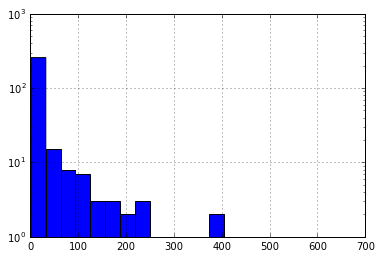

In [17]:
feat[(feat.final_result == 1) & (feat.num_amends > 0)]['num_amends'].hist(bins=20)
plt.yscale('log', nonposy='clip')

554


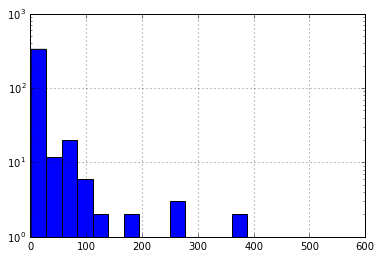

In [16]:
print(np.max(feat[(feat.final_result == 0) & (feat.num_amends > 0)]['num_amends']))
feat[(feat.final_result == 0) & (feat.num_amends > 0)]['num_amends'].hist(bins=20)
plt.yscale('log', nonposy='clip')

In [15]:
feat.hist?